In [2]:
import numpy as np
import Plot as plot
import math
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as offline
import time
import datetime
import pickle
import os
import scipy.spatial
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib as plt
import logging
from scipy import signal
import learningAlgs as classImportLA
import dataManipulation as dataMan
from itertools import permutations
import importlib
from datetime import timedelta
from multiprocessing import Pool
import multiprocessing
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.cluster import KMeans
import timeIntervalPlotter as intervalPlotter
import pysal
import warnings
import lumping_traditional as oldLumping
import boundaryFull_SS_WeightedLumping as WLumping
from importlib import reload
from scipy.stats import rayleigh
import dataManipulation as dataMan
import matplotlib.pyplot as plt
import processData as processData
import tensorflow as tf
import random
from random import shuffle

warnings.filterwarnings('always')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Fetching Data and Creating Transition Matrix

In [11]:
dataFrame = processData.processingData()
#address is: /home/netlab/Desktop/thesis/data/1node1-3-5/
#/home/netlab/Desktop/thesis/data/500f80271400/
data = dataFrame.copy() #copying the dataFrame to have a copy of not edited data

data = processData.dataFrameManipulation(data)

the address of the collected data files (not alligned files or CSV files): /home/sepehr/thesis/data/500f80271400/
['500f80271400.txt']
here
500f80271400.txt is in csvChecker

we have the csv file: pulling out data

   col1                time  CU
0     0 2018-11-13 02:01:32  45
1     1 2018-11-13 02:01:38  45
2     2 2018-11-13 02:01:44  51
3     3 2018-11-13 02:01:50  53
4     4 2018-11-13 02:01:56  45
now we have the processed data from pandas
please enter how long would be the chunk minutes? 60
removing weekends from the data


In [12]:
numberOfStates = 255
cuTrans_60min = processData.markovianTransitionMatrixDegree1(data, numberOfStates, "CU")
normalizedCuTrans_60min = processData.normalizingTransMatrix(cuTrans_60min)
cuTrans_cpy = normalizedCuTrans_60min.copy()

In [14]:
for x in range(max(data["timeIndex"]) + 1):
    print(x)
    maximum = 0
    counter = 1
    for i in range(len(cuTrans_cpy[x])):
        if int(np.sum(cuTrans_cpy[x][i])) != 0:
            if (counter > maximum):
                maximum = counter
            counter = 1
        elif int(np.sum(cuTrans_cpy[x][i])) == 0 and int(np.sum(cuTrans_cpy[x].T[i])) == 0:
            counter += 1
    if (max(maximum, counter)/255 * 100) > 25:
        print(x, max(maximum, counter)/255 * 100)
        print("this tau value does not work for all time-intervals")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


# Calculating days and shuffling with seed to create Correlations

In [15]:
def dayCalculator(x):
    years = x["time"].year - data["time"][0].year
    months = x["time"].month - data["time"][0].month
    days = x["time"].day - data["time"][0].day
    return ((years*12*30) + (months*30) + days)
data["day"] = data.apply(lambda x: dayCalculator(x), axis = 1)

In [16]:
uniqueDays = []
uniqueDays.extend(data.apply(lambda x: x["day"] if x["day"] not in uniqueDays else np.inf, axis = 1))
uniqueDays = list(set(uniqueDays))
random.Random(0).shuffle(uniqueDays)

days30 = uniqueDays[0:30]
data_within_30Days = data.loc[data["day"].isin(days30)]

In [17]:
numberOfStates = 255
cuTrans_30Days = processData.markovianTransitionMatrixDegree1(data_within_30Days, numberOfStates, "CU")
normalizedCuTrans_30Days = processData.normalizingTransMatrix(cuTrans_30Days)

In [18]:
from scipy import signal
pd.options.mode.chained_assignment = None
steadyState_30days = np.zeros(shape=(normalizedCuTrans_30Days.shape[0],
                                     normalizedCuTrans_30Days.shape[1]))
for i in range(normalizedCuTrans_30Days.shape[0]):
    steadyState_30days[i] = abs(pysal.spatial_dynamics.ergodic.steady_state(normalizedCuTrans_30Days[i]))

In [26]:
max(data["timeIndex"])

23

# Calculating Correlations

In [20]:
for x in range(max(data["timeIndex"])+1):
    data["corr" + str(x + 1)] = np.inf

In [21]:
print(uniqueDays)
for j in uniqueDays:
    print(j)
    for i in range(max(data["timeIndex"])+1):
        data_correlation = data.loc[(data["timeIndex"] == i) & (data["day"] == j)].copy()
        if len(data_correlation) == 0:
            continue
        cuTran_corr = processData.markovianTransitionMatrixDegree1(data_correlation, numberOfStates, "CU")
        for x in range(cuTran_corr[-1].shape[0]):
            if np.sum(cuTran_corr[-1][x]) == 0:
                continue
            cuTran_corr[-1][x] = cuTran_corr[-1][x] / np.sum(cuTran_corr[-1][x])
        steadyState_corr = abs(pysal.spatial_dynamics.ergodic.steady_state(cuTran_corr[-1]))

        steadyState_corr_normalize = (steadyState_corr - np.mean(steadyState_corr)) / (
            np.std(steadyState_corr) * len(steadyState_corr))
        
        correlationDistance = []
        
        for x in range(max(data["timeIndex"])+1):
            ss_normalize = (steadyState_30days[x] - np.mean(steadyState_30days[x])) / (
                np.std(steadyState_30days[x]))
            data["corr" + str(x + 1)].loc[(data["timeIndex"] == i) & (data["day"] == j)] = signal.correlate(
                steadyState_corr_normalize, ss_normalize, mode="valid")[0]

[31, 10, 15, 9, 185, 17, 1, 252, 257, 195, 22, 205, 191, 167, 238, 2, 184, 246, 224, 210, 25, 8, 32, 14, 201, 147, 30, 146, 240, 161, 254, 236, 177, 264, 245, 141, 153, 219, 178, 18, 243, 216, 4, 28, 21, 29, 148, 223, 198, 211, 218, 189, 215, 35, 260, 183, 259, 0, 217, 154, 199, 253, 3, 258, 197, 251, 36, 164, 196, 250, 247, 202, 168, 11, 239, 163, 24, 225, 212, 149, 237, 16, 244, 160, 23, 208, 37, 222, 182, 203, 162, 190, 204, 209, 150, 7, 192, 188]
31
10
15
9
185
17
1
252
257
195
22
205
191
167
238
2
184
246
224
210
25
8
32
14
201
147
30
146
240
161
254
236
177
264
245
141
153
219
178
18
243
216
4
28
21
29
148
223
198
211
218
189
215
35
260
183
259
0
217
154
199
253
3
258
197
251
36
164
196
250
247
202
168
11
239
163
24
225
212
149
237
16
244
160
23
208
37
222
182
203
162
190
204
209
150
7
192
188


# Creating Staionary Process Values

In [22]:
copy_data = data.copy()
data["logDiff"] = np.inf
data["log"] = np.inf
data["normalLogDiff"] = np.inf

In [23]:
for i in range(np.max(data["timeIndex"]) + 1):
    dataTimeIndex = data.loc[data["timeIndex"] == i]
    dataTimeIndex["log"] = np.log(dataTimeIndex["CU"])
    dataTimeIndex = dataTimeIndex.loc[dataTimeIndex["log"] != -np.inf]
    dataTimeIndex = dataTimeIndex.loc[dataTimeIndex["log"] != np.inf]
    dataTimeIndex = dataTimeIndex.dropna()
    
    dataTimeIndex["logDiff"] = dataTimeIndex["log"].diff()
    dataTimeIndex = dataTimeIndex.loc[dataTimeIndex["logDiff"] != -np.inf]
    dataTimeIndex = dataTimeIndex.loc[dataTimeIndex["logDiff"] != -np.inf]
    dataTimeIndex = dataTimeIndex.dropna()
    
    dataTimeIndex["normalLogDiff"] = dataTimeIndex["logDiff"] / np.max(dataTimeIndex["logDiff"])
    data.loc[data["timeIndex"] == i] = dataTimeIndex
    
data = data.loc[data["log"] != np.inf]
data = data.loc[data["log"] != -np.inf]
data = data.dropna()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeW

# Writing Feature Engineered DataFrame into a Pickle

In [24]:
data["timeIndex"] = data["timeIndex"].astype(int)
data.to_pickle("60min_featureEngineer.pickle")

In [25]:
data.head()

,col1,time,CU,CU/255,timeIndex,weekDay,day,corr1,corr2,corr3,...,corr18,corr19,corr20,corr21,corr22,corr23,corr24,logDiff,log,normalLogDiff
1,1.0,2018-11-12 19:01:38,45.0,0.176471,19,0.0,0.0,0.798863,0.787328,0.814917,...,0.510812,0.518949,0.595878,0.733483,0.746124,0.759237,0.768665,0.000000,3.806662,0.000000
2,2.0,2018-11-12 19:01:44,51.0,0.200000,19,0.0,0.0,0.798863,0.787328,0.814917,...,0.510812,0.518949,0.595878,0.733483,0.746124,0.759237,0.768665,0.125163,3.931826,0.052939
3,3.0,2018-11-12 19:01:50,53.0,0.207843,19,0.0,0.0,0.798863,0.787328,0.814917,...,0.510812,0.518949,0.595878,0.733483,0.746124,0.759237,0.768665,0.038466,3.970292,0.016270
4,4.0,2018-11-12 19:01:56,45.0,0.176471,19,0.0,0.0,0.798863,0.787328,0.814917,...,0.510812,0.518949,0.595878,0.733483,0.746124,0.759237,0.768665,-0.163629,3.806662,-0.069209
5,5.0,2018-11-12 19:02:02,45.0,0.176471,19,0.0,0.0,0.798863,0.787328,0.814917,...,0.510812,0.518949,0.595878,0.733483,0.746124,0.759237,0.768665,0.000000,3.806662,0.000000


In [27]:
data = pd.read_pickle("60min_featureEngineer.pickle")

In [28]:
numberOfStates = 255
cuTrans = processData.markovianTransitionMatrixDegree1(data, numberOfStates, "CU")
normalizedCuTrans = processData.normalizingTransMatrix(cuTrans)

In [29]:
def preparingMatrixForLumping(transitionMatrix):
    reload(oldLumping)
    percentageMatrix_list = bandwidthPercentage(transitionMatrix)
    zero_cols_rows = []
    #*************removing zeros from columns and rows (matrix reduction) ****************
    for i in range(len(transitionMatrix)):
        if (np.sum(transitionMatrix[i]) == 0) and (np.sum(transitionMatrix[:,i]) == 0):
            zero_cols_rows.append(i)


    irreducible_matrix = transitionMatrix.copy()
    for i in range(len(zero_cols_rows) - 1, -1, -1):
        irreducible_matrix = np.delete(irreducible_matrix, zero_cols_rows[i], axis = 0)
        irreducible_matrix = np.delete(irreducible_matrix, zero_cols_rows[i], axis = 1)
        percentageMatrix_list[zero_cols_rows[i]][2] = True


    for i in range(len(percentageMatrix_list) - 1, 0, -1):
        if (percentageMatrix_list[i][2] == True) and (percentageMatrix_list[i - 1][2] == True):
            percentageMatrix_list[i - 1][0].extend(percentageMatrix_list[i][0])
            percentageMatrix_list[i - 1][1] = percentageMatrix_list[i][1]
            del percentageMatrix_list[i]

    for i in range(len(irreducible_matrix)):
        if np.sum(irreducible_matrix[i], dtype = np.float32) != 1.0:
            print(np.sum(irreducible_matrix[i], dtype = np.float32))

    return percentageMatrix_list, irreducible_matrix

def bandwidthPercentage(vectorMatrix):
    percentageIncreament = (100 / vectorMatrix.shape[0])
    percentageMatrix = []
    maxPercentage = 0
    for j in range(vectorMatrix.shape[0]):
        maxPercentage += percentageIncreament
        percentageMatrix.append([[j], maxPercentage, False])

    return percentageMatrix

In [30]:
reload(oldLumping)

<module 'lumping_traditional' from '/home/sepehr/thesis/APDataML/lumping_traditional.py'>

In [31]:
normalizedCuTrans.shape

(24, 255, 255)

In [33]:
for i in range((max(data["timeIndex"]) + 1)):
    percentageMatrix_list, irreducible_matrix = preparingMatrixForLumping(normalizedCuTrans[i])
    result = oldLumping.lumping(irreducible_matrix, percentageMatrix_list, False)
    nameResult = "/home/sepehr/thesis/APDataML/pickles/5normal_25-10_lumping_60min_result_" + str(i) + ".pickle"
    with open(nameResult, 'wb') as handle:
        pickle.dump(result, handle)
    namePercent = "/home/sepehr/thesis/APDataML/pickles/5normal_25-10_lumping_60min_percentage_" + str(i) + ".pickle"
    with open(namePercent, 'wb') as handle:
        pickle.dump(percentageMatrix_list, handle)

0.99999994
0.99999994
1.0000001
0.99999994
0.99999994
0.99999994
1.0000001
0.99999994
we have these many sectors to check:  295382
0.99999994
1.0000001
we have these many sectors to check:  35480
0.99999994
0.99999994
1.0000001
0.99999994
0.99999994
0.99999994
we have these many sectors to check:  75550
0.99999994
0.99999994
0.99999994
0.99999994
1.0000001
we have these many sectors to check:  18336
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
1.0000001
1.0000001
we have these many sectors to check:  11082
0.99999994
0.9999999
0.99999994
0.99999994
0.99999994
0.99999994
we have these many sectors to check:  5766
0.99999994
1.0000001
0.99999994
0.99999994
1.0000001
0.99999994
1.0000001
we have these many sectors to check:  30657
0.99999994
0.99999994
0.99999994
0.99999994
0.9999999
0.99999994
we have these many sectors to check:  224326
0.99999994
0.99999994
0.99999994
0.99999994
0.9999999
1.0000001
0.99999994
0.9999999
we have these many sectors to check:  308438
0

In [36]:
arrayOfLumpes = []
indexesOfCandidates = [[] for i in range((max(data["timeIndex"]) + 1))]
for timeIndex in range((max(data["timeIndex"]) + 1)):
    print(timeIndex)
    name = "/home/sepehr/thesis/APDataML/pickles/5normal_25-10_lumping_60min_result_" + str(timeIndex) + ".pickle"
    with open(name, 'rb') as handle:
        b = pickle.load(handle)
    
    if len(b) > 0:
        minDegree = np.inf        
        for i in range(len(b)):
            if b[i][0] < minDegree:
                minDegree = b[i][0]

        minError = np.inf
        for i in range(len(b)):
            if b[i][0] == minDegree and b[i][1] < minError:
                minError = b[i][1]

        for i in range(len(b)):
            if b[i][0] == minDegree and b[i][1] == minError:
                indexesOfCandidates[timeIndex].append(b[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [37]:
name = "/home/sepehr/thesis/APDataML/pickles/5normal_25-10_lumping_60min.pickle"
with open(name, 'wb') as handle:
    pickle.dump(indexesOfCandidates, handle) 

In [34]:
reload(oldLumping)

<module 'lumping_traditional' from '/home/sepehr/thesis/APDataML/lumping_traditional.py'>

In [35]:
for i in range((max(data["timeIndex"]) + 1)):
    percentageMatrix_list, irreducible_matrix = preparingMatrixForLumping(normalizedCuTrans[i])
    result = oldLumping.lumping(irreducible_matrix, percentageMatrix_list, False)
    nameResult = "/home/sepehr/thesis/APDataML/pickles/4normal_25-10_lumping_60min_result_" + str(i) + ".pickle"
    with open(nameResult, 'wb') as handle:
        pickle.dump(result, handle)
    namePercent = "/home/sepehr/thesis/APDataML/pickles/4normal_25-10_lumping_60min_percentage_" + str(i) + ".pickle"
    with open(namePercent, 'wb') as handle:
        pickle.dump(percentageMatrix_list, handle)

0.99999994
0.99999994
1.0000001
0.99999994
0.99999994
0.99999994
1.0000001
0.99999994
we have these many sectors to check:  9380
0.99999994
1.0000001
we have these many sectors to check:  1888
0.99999994
0.99999994
1.0000001
0.99999994
0.99999994
0.99999994
we have these many sectors to check:  3031
0.99999994
0.99999994
0.99999994
0.99999994
1.0000001
we have these many sectors to check:  1347
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
1.0000001
1.0000001
we have these many sectors to check:  338
0.99999994
0.9999999
0.99999994
0.99999994
0.99999994
0.99999994
we have these many sectors to check:  24
0.99999994
1.0000001
0.99999994
0.99999994
1.0000001
0.99999994
1.0000001
we have these many sectors to check:  4014
0.99999994
0.99999994
0.99999994
0.99999994
0.9999999
0.99999994
we have these many sectors to check:  10885
0.99999994
0.99999994
0.99999994
0.99999994
0.9999999
1.0000001
0.99999994
0.9999999
we have these many sectors to check:  12500
0.99999994
0.

In [38]:
arrayOfLumpes = []
indexesOfCandidates = [[] for i in range((max(data["timeIndex"]) + 1))]
for timeIndex in range((max(data["timeIndex"]) + 1)):
    print(timeIndex)
    name = "/home/sepehr/thesis/APDataML/pickles/4normal_25-10_lumping_60min_result_" + str(timeIndex) + ".pickle"
    with open(name, 'rb') as handle:
        b = pickle.load(handle)
    
    if len(b) > 0:
        minDegree = np.inf        
        for i in range(len(b)):
            if b[i][0] < minDegree:
                minDegree = b[i][0]

        minError = np.inf
        for i in range(len(b)):
            if b[i][0] == minDegree and b[i][1] < minError:
                minError = b[i][1]

        for i in range(len(b)):
            if b[i][0] == minDegree and b[i][1] == minError:
                indexesOfCandidates[timeIndex].append(b[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [40]:
name = "/home/sepehr/thesis/APDataML/pickles/4normal_25-10_lumping_60min.pickle"
with open(name, 'wb') as handle:
    pickle.dump(indexesOfCandidates, handle) 

In [47]:
def classifying(CU, boundaries):
    occupiedBandwidth = (CU / 255) * 100
    for i in range(len(boundaries)):
        if occupiedBandwidth <= boundaries[i]:
            return i
        
def dataPreparation(data, timeIndexes, minuteSplit, boundaries):
    from sklearn.utils import shuffle
    warnings.filterwarnings('always')
    reg = "l2"
    solvers = "lbfgs"
    clf = LogisticRegression(penalty = reg, max_iter = 100000, random_state = 0,
                             solver = solvers , multi_class = 'multinomial')
    accuracyValue = 0
    numOfElements = 0
    f1scoreValue = 0
    precisionValue = 0
    recallValue = 0
    prevRowTrain = np.inf
    prevCU = np.inf

    sampleIntervals = 6 #seconds
    minuteSplit = 30 #minutes
    numOfSamples = minuteSplit * 60 / sampleIntervals
    # numberOfDays = len(numOfDays)
    days = np.zeros(7)
    numOfThirtyMinsPerDay = np.zeros(int((24 * 60) / minuteSplit)) #in this case 48
#     which6SecondsPerPeriod = np.zeros(int(minuteSplit * 60 / sampleIntervals)) #in this case 300
    prevRowTrain = np.inf
    prevCU = np.inf

    XArraysForLearning = []
    YArraysForLearning = []
    XArraysForTesting = []
    YArraysForTesting = []

    x = timeIndexes
    wholeDataFrame = data.loc[(data["timeIndex"] == x)].copy()
    
    wholeDataFrame["cuClass"] = wholeDataFrame["CU"].apply(lambda x: classifying(x, boundaries))

    

    stackCounter = 0
    prevCU = 0
    prev2CU = 0
    prev3CU = 0
    prev4CU = 0
    prev5CU = 0
    print("start training set generation")
    #number of features are: prevCU + 48 correlations + 1 logDiff
    numberOfFeatures = len(boundaries) + 24 + 1 
    
    XArraysForLearning = np.zeros(shape=(len(wholeDataFrame), numberOfFeatures))
    YArraysForLearning = np.zeros(shape=(len(wholeDataFrame), len(boundaries)))
#     print(len(trainingDataFrame))
    counter = 0
    pandasIndexCounter = 0
    for index, row in wholeDataFrame.iterrows():
        XArraysForLearning[pandasIndexCounter, prevCU] = 1
        for corrs in range(24):
            XArraysForLearning[pandasIndexCounter, len(boundaries) + corrs] = row["corr" + str(corrs + 1)]

        XArraysForLearning[pandasIndexCounter, len(boundaries) + 24] = row["normalLogDiff"]
        YArraysForLearning[pandasIndexCounter, row["cuClass"]] = 1
#         print(XArraysForLearning[pandasIndexCounter])

        which6SecondsPerPeriod = 0
    
        prevCU = row["cuClass"]
        pandasIndexCounter += 1

    XArraysForLearning, YArraysForLearning = shuffle(XArraysForLearning, YArraysForLearning, random_state=0)
    XArraysForTraining = XArraysForLearning[:int(0.8*len(XArraysForLearning))]
    YArraysForTraining = YArraysForLearning[:int(0.8*len(YArraysForLearning))]
    XArraysForTesting = XArraysForLearning[int(0.8*len(XArraysForLearning)):]
    YArraysForTesting = YArraysForLearning[int(0.8*len(YArraysForLearning)):]
    print(XArraysForTraining.shape[0])
    print(XArraysForTesting.shape[0])


    return XArraysForTraining, YArraysForTraining, XArraysForTesting, YArraysForTesting, boundaries

def tensorFlowLossFunction(
    lossFuncBool, XArraysForLearning, YArraysForLearning, XArraysForTesting, YArraysForTesting, boundaries):
    
    batch_size = 64
    learning_rate = 0.01
    beta = 0.1
    numOfEpochs = 5000
    graph = tf.Graph()
    with graph.as_default():
        x = tf.placeholder(tf.float32, shape = (batch_size, XArraysForLearning.shape[1]))
        y_ = tf.placeholder(tf.float32, shape = (batch_size, YArraysForLearning.shape[1]))
#         print(weights.dtype)
#         print(weights.shape)
#         print(XArraysForLearning.shape[1], YArraysForLearning.shape[1])
#         multiDistrib = np.vstack((mult, mult))
#         for i in range(batch_size - 2):
#             multiDistrib = np.vstack((multiDistrib, mult))
        W = tf.Variable(tf.truncated_normal([XArraysForLearning.shape[1], YArraysForLearning.shape[1]], seed = 0), name="weights", dtype=tf.float32)
        b = tf.Variable(tf.truncated_normal([YArraysForLearning.shape[1]], seed = 0), dtype=tf.float32)

        tf_test_dataset64 = tf.constant(XArraysForTesting)
        tf_test_dataset = tf.cast(tf_test_dataset64, tf.float32)


        beta = 0.05
        logits = tf.matmul(x, W)
        train_prediction = tf.nn.softmax(logits)
        # train_prediction = tf.nn.softmax_cross_entropy_with_logits_v2(labels = y_, logits = logits)
        test_prediction = tf.nn.softmax(tf.add(tf.matmul(tf_test_dataset, W),b))

        # x = XArraysForLearning[0:(0 + batch_size), :]
        # y_ = tf.Variable(YArraysForLearning[0:(0 + batch_size), :])

        # loss = assymetricLossFunction(train_prediction, y_, boundaries)
        # loss = assymetricLossFunction(train_prediction, y_, boundaries)
        
        if lossFuncBool == 0:
            loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = y_)
        
        elif lossFuncBool == 1:
            loss = assymetricLossFunction(train_prediction, y_, boundaries)
#         dist = tfp.distributions.Multinomial(total_count=1, logits=logits)
#         loss = loss - (dist.log_prob(mult))
        # regularizer = tf.nn.l2_loss(W)
        # loss = tf.reduce_mean(loss + beta * regularizer)
        # loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits = train_prediction, labels = y_)
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

        prevAcc = 0
        prevLoss = np.inf

    with tf.Session(graph=graph) as session:
        initializer = tf.contrib.layers.xavier_initializer()
        tf.set_random_seed(0)
        W = tf.Variable(initializer([XArraysForLearning.shape[1], YArraysForLearning.shape[1]]))
        b = tf.Variable(initializer([YArraysForLearning.shape[1]]))       
        tf.global_variables_initializer().run()
#         print(W.eval())
        
        print("Initialized")

        numberOfBatchIteration = int(XArraysForLearning.shape[0] / batch_size)
        restOfData = XArraysForLearning.shape[0] % batch_size
        if restOfData != 0:
            numberOfBatchIteration += 1

        accuracy_result = 0
        accuracy_earlyStop = 0
        earlyStoppingCounter = 0
        
        for epoch in range(numOfEpochs):
            accuracyValue = 0
            lossValue = 0
            totalBatch = 0
            i = 0
            randomize = np.arange(XArraysForLearning.shape[0])
            random.Random(epoch).shuffle(randomize)
            XArraysForLearning = XArraysForLearning[randomize]
            YArraysForLearning = YArraysForLearning[randomize]

            for iteration in range(numberOfBatchIteration):
                if (iteration == numberOfBatchIteration - 1) and restOfData != 0:
                    break
                    batch_data = XArraysForLearning[i:, :]
                    batch_labels = YArraysForLearning[i:, :]

                else:
                    batch_data = XArraysForLearning[i:(i + batch_size), :]
                    batch_labels = YArraysForLearning[i:(i + batch_size), :]

                    i += batch_size


                feed_dict = {x : batch_data, y_ : batch_labels}
                _, predictions, l = session.run([optimizer, train_prediction, loss], feed_dict=feed_dict)

#                 print(l)
                lossValue *= (iteration)
                lossValue += (np.sum(l))
                lossValue /= (iteration + 1)
                totalBatch += batch_size
                # print(accuracy(batch_data, batch_labels))
                
                accuracyValue += accuracy(predictions, batch_labels) * batch_size


            totalAccuracy = accuracyValue/totalBatch
#             print(session.run(W))
#             test_result = test_prediction.eval()
            if epoch % 20 == 0:
                print("epoch ", epoch, totalAccuracy, lossValue)
                
            if lossValue > prevLoss and earlyStoppingCounter == 50:
                break

            elif lossValue > prevLoss:
                earlyStoppingCounter += 1

            elif lossValue <= prevLoss:
                prevLoss = lossValue
                earlyStoppingCounter = 0
#             print(lossValue, prevLoss)
                
            



        # print(session.run(W))
        predictionResult = test_prediction.eval()
        accResult = accuracy(predictionResult , YArraysForTesting)
        penaltyValue = assymetricPredictionScore(predictionResult, YArraysForTesting, boundaries)
#         print(W.eval())
        accuracy_result = accResult
            
        correctLableIndex = np.argmax(YArraysForTesting, 1)
        predictionIndex = np.argmax(predictionResult, 1)
        
        precision = precision_score(correctLableIndex, predictionIndex, average='weighted')
        recall = recall_score(correctLableIndex, predictionIndex, average='weighted')
        f1Score = f1_score(correctLableIndex, predictionIndex, average='weighted')            
        
        return accuracy_result, penaltyValue, precision, recall, f1Score

            
    
def assymetricPredictionScore(predictedLables, trueLables, boundaries):
    xAxisPoints = np.linspace(rayleigh.ppf(0.01), rayleigh.ppf(0.99), 338)
    #number of overal datapoints must stay the same all the time
    maxState = 338

    inverseDistrib = max(rayleigh.pdf(xAxisPoints)) - rayleigh.pdf(xAxisPoints)
    minState = np.argmin(inverseDistrib)

    underUtilizedSum = 0
    overUtilizedSum = 0
    numberOfUnderUtilizedStates = minState - 0
    numberOfOverUtilizedStates = maxState - minState

    xAxisPoints -= xAxisPoints[np.argmin(inverseDistrib)]

    underUtilVal = numberOfUnderUtilizedStates / 100
    overUtilVal = numberOfOverUtilizedStates / 100

    correctLableIndex = np.argmax(trueLables, 1)
    predictionIndex = np.argmax(predictedLables, 1)

    diffPercentage = np.zeros(shape = (predictedLables.shape))

    penalties = np.zeros(shape = (predictedLables.shape))

    for index in range(predictedLables.shape[0]):
        diffPercentage[index] = boundaries[correctLableIndex[index]] - boundaries[:]


    for i in range(diffPercentage.shape[0]):
        for j in range(diffPercentage.shape[1]):
            if diffPercentage[i][j] > 0:
                penalties[i][j] = inverseDistrib[minState + math.floor
                                                  (diffPercentage[i][j] * overUtilVal)]
            else:
                penalties[i][j] = inverseDistrib[minState + math.floor
                                                  (diffPercentage[i][j] * underUtilVal)]

    sumOfPenalty = 0
    for i in range(predictionIndex.shape[0]):
        sumOfPenalty += penalties[i][predictionIndex[i]]

    return sumOfPenalty
    
    
def accuracy(predictedLables, trueLables):
    import sys
    np.set_printoptions(threshold=sys.maxsize)
    correctLableIndex = np.argmax(trueLables, 1)
    predictionIndex = np.argmax(predictedLables, 1)
    errors = [0 for i in range(trueLables.shape[1])]
    corrects = [0 for i in range(trueLables.shape[1])]
    for i in range(len(correctLableIndex)):
        if correctLableIndex[i] != predictionIndex[i]:
            errors[correctLableIndex[i]] += 1
            corrects[predictionIndex[i]] += 1

    acc = np.float64(np.sum(correctLableIndex == predictionIndex)/predictedLables.shape[0])
    return acc
    
    
def assymetricLossFunction(prediction, correctLable, boundaries):
    xAxisPoints = np.linspace(rayleigh.ppf(0.01), rayleigh.ppf(0.99), 338)
    #number of overal datapoints must stay the same all the time
    maxState = 338
    inverseDistrib = max(rayleigh.pdf(xAxisPoints)) - rayleigh.pdf(xAxisPoints)
    inverseDistrib = tf.constant(inverseDistrib)
    xAxisPoints -= xAxisPoints[np.argmin(inverseDistrib)]
    minState = np.argmin(inverseDistrib)
    numberOfOverUtilizedStates = maxState - minState
    numberOfUnderUtilizedStates = minState
    minState = tf.constant(minState, tf.float32)
    numberOfOverUtilizedStates = tf.constant(numberOfOverUtilizedStates, tf.float32)
    numberOfUnderUtilizedStates = tf.constant(numberOfUnderUtilizedStates, tf.float32)

    underUtilVal = numberOfUnderUtilizedStates / 100
    overUtilVal = numberOfOverUtilizedStates / 100


    boundaries = tf.constant(boundaries, tf.float32)
    correctLableIndex = tf.argmax(correctLable, 1)

    diffPercentage = []
    for index in range(correctLableIndex.shape[0]):
        diffPercentage.append(boundaries[correctLableIndex[index]] - boundaries[:])

    diffPercentage = tf.stack(diffPercentage)

    penalties = []

    counter = 0
    for i in range(diffPercentage.shape[0]):
        for j in range(diffPercentage.shape[1]):
            counter += 1

            penalties.append(tf.cond(
                    tf.greater(diffPercentage[i][j], 0),
                    lambda: inverseDistrib[tf.dtypes.cast(minState + tf.math.floor
                                                                   (tf.math.scalar_mul(diffPercentage[i][j],
                                                                                       overUtilVal)), tf.int32)],
                    lambda: inverseDistrib[tf.dtypes.cast(minState + tf.math.floor
                                                                   (tf.math.scalar_mul
                                                                    (diffPercentage[i][j], underUtilVal))
                                                                   , tf.int32)]
                    ))

    penalties = tf.stack(penalties)
    penalties = tf.dtypes.cast(penalties, tf.float32)
    penalties = tf.reshape(penalties, diffPercentage.shape)
    penalties = penalties / tf.norm(penalties)

    # weights = tf.reduce_sum(penalties * (1-prediction), axis=1)
    weights = (1 - penalties) * prediction
    weights = weights / tf.norm(weights)
    # print(correctLable)
    # print(prediction)
    # print(penalties)
    loss = tf.losses.softmax_cross_entropy(onehot_labels = correctLable, logits = weights)
    # weighted_losses = tf.nn.softmax_cross_entropy_with_logits_v2(labels = penalties, logits = prediction)
    # loss = tf.reduce_sum(weighted_losses)
    # loss = tf.reduce_sum(penalties * prediction)
    return tf.reduce_mean(loss)

In [42]:
cuTran_cpy = normalizedCuTrans_60min.copy()

In [43]:
name = "/home/sepehr/thesis/APDataML/pickles/5normal_25-10_lumping_60min.pickle"
with open(name, 'rb') as handle:
    normalLumping = pickle.load(handle)

In [44]:
percentageArray = []
for i in range(len(normalLumping)):
    name = "/home/sepehr/thesis/APDataML/pickles/5normal_25-10_lumping_60min_percentage_" + str(i) + ".pickle"
    with open(name, 'rb') as handle:
        percentageArray.append(pickle.load(handle))

In [45]:
accuracyResult = [np.inf for i in range(len(normalLumping))]
penaltyResult = [np.inf for i in range(len(normalLumping))]
precisionResult = [np.inf for i in range(len(normalLumping))]
recallResult = [np.inf for i in range(len(normalLumping))]
f1ScoreResult = [np.inf for i in range(len(normalLumping))]
boundariesResult = [np.inf for i in range(len(normalLumping))]
lumpAproxResult = [np.inf for i in range(len(normalLumping))]
lumpErrorResult = [np.inf for i in range(len(normalLumping))]


testDataFrame = {"accuracy": accuracyResult, "penalty": penaltyResult, "precision": precisionResult, 
                 "recall": recallResult, "f1Score": f1ScoreResult, "boundaries": boundariesResult, 
                 "lumpAprox": lumpAproxResult, "lumpError": lumpErrorResult}

result_25_10_6class_60min_DataFrameNoPenalty = pd.DataFrame(testDataFrame)
result_25_10_6class_60min_DataFrameNoPenalty = result_25_10_6class_60min_DataFrameNoPenalty.astype('object')

result_25_10_6class_60min_DataFrameNoPenalty = pd.DataFrame(testDataFrame)
result_25_10_6class_60min_DataFrameNoPenalty = result_25_10_6class_60min_DataFrameNoPenalty.astype('object')

In [48]:
warnings.filterwarnings('ignore')
for timeIndex in range(len(normalLumping)):
    if len(normalLumping[timeIndex]) == 0:
        continue
    
    print(timeIndex)
    boundaries = np.array([])
    for i in range(1, len(normalLumping[0][0][3])):
        bound = normalLumping[timeIndex][0][3][i] + 1
        counter = 0
        for j in range(len(percentageArray[timeIndex])):
            if percentageArray[timeIndex][j][2] == False:
                counter += 1
            if counter == bound:
                boundaries = np.append(boundaries, percentageArray[timeIndex][j][1])
                break
    boundaries = np.append(boundaries,100)
    print(boundaries)
    
    XArraysForLearning, YArraysForLearning, XArraysForTesting, YArraysForTesting, boundaries = dataPreparation(
        data, timeIndex, 30, boundaries)

    print("starting tensor")
    lossFunctionBoolean = 0
    accuracy_result, penaltyValue, precision, recall, f1Score = tensorFlowLossFunction(
        lossFunctionBoolean, XArraysForLearning, YArraysForLearning, XArraysForTesting, 
        YArraysForTesting, boundaries)
    
    result_25_10_6class_60min_DataFrameNoPenalty.loc[timeIndex]["accuracy"] = accuracy_result
    result_25_10_6class_60min_DataFrameNoPenalty.loc[timeIndex]["penalty"] = penaltyValue
    result_25_10_6class_60min_DataFrameNoPenalty.loc[timeIndex]["precision"] = precision
    result_25_10_6class_60min_DataFrameNoPenalty.loc[timeIndex]["recall"] = recall
    result_25_10_6class_60min_DataFrameNoPenalty.loc[timeIndex]["f1Score"] = f1Score
    result_25_10_6class_60min_DataFrameNoPenalty.loc[timeIndex]["boundaries"] = boundaries
    result_25_10_6class_60min_DataFrameNoPenalty.loc[timeIndex]["lumpAprox"] = normalLumping[timeIndex][0][0]
    result_25_10_6class_60min_DataFrameNoPenalty.loc[timeIndex]["lumpError"] = normalLumping[timeIndex][0][1]

    

0
[ 10.19607843  32.15686275  51.37254902  71.37254902  82.35294118
 100.        ]
start training set generation
37896
9475
starting tensor
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Initialized
epoch  0 0.8565772804054054 24.252476715558288
epoch  20 0.9329866976351351 10.407262885489978
epoch  40 0.9341744087837838 10.166129386102831
epoch  60 0.9347550675675675 10.072752795912123
epoch  80 0.9354676942567568 9.971936273413734
epoch  100 0.9348078547297297 9.954424748146858
epoch  120 0.9358372043918919 9.933925915408777
epoch  140 0.9352565456081081 9.865325343367212
epoch  160 0.9359163851351351 9.859318934582383
epoch  180 0.9358372043918919 9.861171522656004
epoch 

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



1
[ 10.19607843  34.11764706  48.23529412  59.21568627  76.07843137
 100.        ]
start training set generation
38177
9545
starting tensor
Initialized
epoch  0 0.8595847315436241 23.426615580616385
epoch  20 0.9325188758389261 10.676719001875627
epoch  40 0.9321256291946308 10.4066111009393
epoch  60 0.9337772651006712 10.274520583200765
epoch  80 0.933567533557047 10.155270239250758
epoch  100 0.9345637583892618 10.12879359722137
epoch  120 0.9355599832214765 10.071399506306497
epoch  140 0.9357172818791947 10.017849590954361
epoch  160 0.934878355704698 9.968959489524774
epoch  180 0.9352716023489933 9.950518088052737
epoch  200 0.9361629614093959 9.915758630973388
epoch  220 0.936215394295302 9.868592869115357
epoch  240 0.9366348573825504 9.845501659700545
epoch  260 0.9358745805369127 9.809767575071968
epoch  280 0.9357434983221476 9.807983492844842
epoch  300 0.936189177852349 9.789443542093238
epoch  320 0.9359007969798657 9.799934403008272
epoch  340 0.9360318791946308 9.76859

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



2
[ 24.31372549  42.35294118  54.11764706  64.31372549  78.03921569
 100.        ]
start training set generation
37746
9437
starting tensor
Initialized
epoch  0 0.9476867572156197 11.211383359136722
epoch  20 0.9628873089983022 6.111602317699958
epoch  40 0.9633648132427843 5.9831520635729545
epoch  60 0.9639749575551783 6.027518720092513
epoch  80 0.9627811969439728 5.973233169630954
epoch  100 0.9636566213921901 5.941916274599388
epoch  120 0.9635239813242784 5.934606357624656
epoch  140 0.9630730050933786 5.916916393059828
epoch  160 0.9637892614601019 5.918616447667312
epoch  180 0.9634443972835314 5.862703787855464


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



3
[ 23.1372549   34.11764706  48.23529412  61.17647059  84.31372549
 100.        ]
start training set generation
37448
9363
starting tensor
Initialized
epoch  0 0.9305288461538461 14.13561233985118
epoch  20 0.9540331196581197 7.542882461221809
epoch  40 0.9536057692307692 7.434407356661609
epoch  60 0.9542200854700855 7.402943584654066
epoch  80 0.9543269230769231 7.356353712897016
epoch  100 0.9545673076923077 7.382375198704566
epoch  120 0.9541132478632479 7.323275300987765
epoch  140 0.9544871794871795 7.316185671651465
epoch  160 0.9545940170940171 7.300231438212925
epoch  180 0.9545673076923077 7.342681295749468
epoch  200 0.9547275641025641 7.298032712732625
epoch  220 0.9544337606837607 7.28434280992573
epoch  240 0.9545138888888889 7.3029532155420025
epoch  260 0.9543269230769231 7.269282776575822
epoch  280 0.9544070512820513 7.310357893430271
epoch  300 0.9548611111111112 7.262960309350593
4
[ 24.31372549  35.29411765  51.37254902  62.35294118  87.05882353
 100.        ]
sta

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



5
[ 10.19607843  34.11764706  51.37254902  70.19607843  88.23529412
 100.        ]
start training set generation
37322
9331
starting tensor
Initialized
epoch  0 0.8666112778730704 22.38165411123076
epoch  20 0.9382772298456261 9.963500345959666
epoch  40 0.9389740566037735 9.791116300618873
epoch  60 0.9380628216123499 9.731552085990971
epoch  80 0.9392956689536878 9.616585715557246
epoch  100 0.9388132504288165 9.604346439319034
epoch  120 0.9397512864493996 9.557694314479019
epoch  140 0.9410377358490566 9.52360269585768
epoch  160 0.9407161234991424 9.505545955170495
epoch  180 0.9413593481989708 9.47819095839767
epoch  200 0.9408769296740995 9.451016116101373
epoch  220 0.9397512864493996 9.431376213479405
epoch  240 0.94085012864494 9.40583529848586
epoch  260 0.9408769296740995 9.410802650615231
epoch  280 0.94028730703259 9.391398456452434
epoch  300 0.940957332761578 9.389344258537426
epoch  320 0.940957332761578 9.378503001574591
epoch  340 0.9405553173241853 9.368173622962328

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



6
[ 10.19607843  32.15686275  50.19607843  60.39215686  76.07843137
 100.        ]
start training set generation
36891
9223
starting tensor
Initialized
epoch  0 0.8625217013888888 23.27072941594654
epoch  20 0.9369845920138888 10.229756588323246
epoch  40 0.9376085069444444 9.993490440977943
epoch  60 0.9375542534722222 9.910529797689788
epoch  80 0.9382866753472222 9.869228030244507
epoch  100 0.9376085069444444 9.832701798321466
epoch  120 0.9382595486111112 9.762665220018881
epoch  140 0.9386393229166666 9.711051821294753
epoch  160 0.9388834635416666 9.719931843380145
epoch  180 0.9387478298611112 9.68450922022263
epoch  200 0.9389919704861112 9.656439356505878
epoch  220 0.9385579427083334 9.672279569216897
epoch  240 0.9382866753472222 9.644332674228478
epoch  260 0.9392632378472222 9.632040054019956
epoch  280 0.9379069010416666 9.66703984431095
epoch  300 0.93896484375 9.637646878759064
epoch  320 0.9385579427083334 9.624231559327914
epoch  340 0.9384494357638888 9.587007252292

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



8
[ 13.33333333  37.25490196  60.39215686  78.03921569  88.23529412
 100.        ]
start training set generation
37100
9276
starting tensor
Initialized
epoch  0 0.8480677892918825 27.51591675022104
epoch  20 0.9175032383419689 13.247096219005158
epoch  40 0.9188795336787565 13.084595332697472
epoch  60 0.918933506044905 13.052742826300376
epoch  80 0.9190684369602763 13.084416175341563
epoch  100 0.9192843264248705 12.958185181510677
epoch  120 0.9193113126079447 12.96231655053318
epoch  140 0.9196891191709845 12.966946030733702
epoch  160 0.9199589810017271 12.903057397750171
epoch  180 0.9203907599309153 12.96022107522928
epoch  200 0.9204987046632125 12.923414732713985
epoch  220 0.9206606217616581 12.881475597671479
epoch  240 0.9203907599309153 12.8707084458109
epoch  260 0.9210114421416234 12.838207918539362
epoch  280 0.9207415803108808 12.833739067400476


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



9
[ 11.37254902  36.07843137  49.01960784  67.05882353  81.17647059
 100.        ]
start training set generation
37436
9360
starting tensor
Initialized
epoch  0 0.8616224315068494 27.551975949169858
epoch  20 0.9173266267123288 13.328628926652748
epoch  40 0.9190122003424658 13.09880733122565
epoch  60 0.9192797517123288 12.99384637074928
epoch  80 0.9198683647260274 12.932312400373696
epoch  100 0.9197345890410958 12.95065157666598
epoch  120 0.918851669520548 12.932960689476088
epoch  140 0.9197078339041096 12.870305826810943
epoch  160 0.9197880993150684 12.89352347426219
epoch  180 0.9196008133561644 12.893591463565828
epoch  200 0.9200288955479452 12.912156512884248
epoch  220 0.9191459760273972 12.937602321579037
10
[ 22.35294118  41.17647059  55.29411765  67.05882353  86.2745098
 100.        ]
start training set generation
38352
9589
starting tensor
Initialized
epoch  0 0.7264190317195326 43.91523056157641
epoch  20 0.8303683222036727 24.98642820189513
epoch  40 0.83201168614357

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



15
[ 11.37254902  35.29411765  51.37254902  72.15686275  82.35294118
 100.        ]
start training set generation
38607
9652
starting tensor
Initialized
epoch  0 0.7959939883913765 37.17187361930735
epoch  20 0.8724087893864013 19.728059391477235
epoch  40 0.8751295605306799 19.378710524557416
epoch  60 0.8751295605306799 19.23642322910366
epoch  80 0.8764251658374793 19.133099336133853
epoch  100 0.8765288142620232 19.099087530107642
epoch  120 0.8764510779436152 19.065185939099262
epoch  140 0.8762956053067993 19.086090892899303
epoch  160 0.8767101990049752 19.023887321130548
epoch  180 0.8762437810945274 19.037382294289493
epoch  200 0.8762178689883914 19.012083539124543
epoch  220 0.8764251658374793 18.94103541223961
epoch  240 0.8771247927031509 18.969653898210666
epoch  260 0.876762023217247 18.94659600961661
epoch  280 0.8773580016583747 18.967051510787133
16
[ 11.37254902  36.07843137  60.39215686  71.37254902  83.1372549
 100.        ]
start training set generation
38490
9623

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



19
[ 11.37254902  36.07843137  60.39215686  72.15686275  88.23529412
 100.        ]
start training set generation
38690
9673
starting tensor
Initialized
epoch  0 0.8383174668874173 27.910358627900383
epoch  20 0.9124586092715232 13.862831662822238
epoch  40 0.9138555463576159 13.623106589380473
epoch  60 0.9142953228476821 13.559240381449266
epoch  80 0.9143470612582781 13.494475870337707
epoch  100 0.9138296771523179 13.51001650094986
epoch  120 0.9140625 13.445376254075414
epoch  140 0.9142177152317881 13.412488545803038
epoch  160 0.9145281456953642 13.391609191499803
epoch  180 0.9137779387417219 13.407287665155547
epoch  200 0.9145798841059603 13.372084583667725
epoch  220 0.9142177152317881 13.352937897704297
epoch  240 0.9145022764900662 13.375663041279015
epoch  260 0.914010761589404 13.374250258041533
epoch  280 0.9131829470198676 13.370052606854227
epoch  300 0.914036630794702 13.331628524704492
epoch  320 0.9145022764900662 13.328110603307257
epoch  340 0.9143211920529801 13

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



23
[ 10.19607843  34.11764706  50.19607843  74.11764706  88.23529412
 100.        ]
start training set generation
38016
9504
starting tensor
Initialized
epoch  0 0.8668718434343434 22.80845195275768
epoch  20 0.9401567760942761 9.689211307952693
epoch  40 0.9412615740740741 9.555730993097468
epoch  60 0.9418665824915825 9.493417842620946
epoch  80 0.9411826599326599 9.414322056152209
epoch  100 0.9414720117845118 9.401695805366582
epoch  120 0.9427346380471381 9.369717185344763
epoch  140 0.9430765993265994 9.344563386255647
epoch  160 0.9423926767676768 9.346427648557155
epoch  180 0.9433396464646465 9.281499331045636
epoch  200 0.9432607323232324 9.323591645719222
epoch  220 0.9431292087542088 9.266837170830483
epoch  240 0.9431292087542088 9.24566948132885
epoch  260 0.9438657407407407 9.233990525155761
epoch  280 0.9444707491582491 9.187443538346285
epoch  300 0.94347117003367 9.260088423687204
epoch  320 0.9429187710437711 9.230213113906807
epoch  340 0.9431292087542088 9.24996478

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



In [49]:
result_25_10_6class_60min_DataFrameNoPenalty

,accuracy,penalty,precision,recall,f1Score,boundaries,lumpAprox,lumpError
0,0.937731,23.4727,0.936423,0.937731,0.934015,"[10.196078431372554, 32.156862745097996, 51.37...",1,44.9435
1,0.935359,27.9766,0.934413,0.935359,0.933699,"[10.196078431372554, 34.11764705882348, 48.235...",1,22.8649
2,0.961534,15.2717,0.960621,0.961534,0.961077,"[24.31372549019606, 42.35294117647051, 54.1176...",1,30.3948
3,0.953327,8.23176,0.957093,0.953327,0.954596,"[23.13725490196077, 34.11764705882348, 48.2352...",1,21.3463
4,0.956773,9.23039,0.960073,0.956773,0.957733,"[24.31372549019606, 35.29411764705877, 51.3725...",1,25.3972
5,0.931411,26.9434,0.930578,0.931411,0.928441,"[10.196078431372554, 34.11764705882348, 51.372...",1,21.7719
6,0.935813,25.3296,0.934784,0.935813,0.93425,"[10.196078431372554, 32.156862745097996, 50.19...",1,27.74
7,0.917429,35.3142,0.913065,0.917429,0.912977,"[11.372549019607849, 36.07843137254896, 50.196...",1,40.4272
8,0.921626,44.537,0.91964,0.921626,0.920215,"[13.333333333333341, 37.25490196078425, 60.392...",1,40.969
9,0.910791,31.7522,0.908068,0.910791,0.906933,"[11.372549019607849, 36.07843137254896, 49.019...",1,41.7307


In [50]:
name = "/home/sepehr/thesis/APDataML/result_25_10_6class_60min_DataFrameNoPenalty.pickle"
with open(name, 'wb') as handle:
    pickle.dump(result_25_10_6class_60min_DataFrameNoPenalty, handle)

In [51]:
name = "/home/sepehr/thesis/APDataML/pickles/4normal_25-10_lumping_60min.pickle"
with open(name, 'rb') as handle:
    normalLumping = pickle.load(handle)

In [52]:
percentageArray = []
for i in range(len(normalLumping)):
    name = "/home/sepehr/thesis/APDataML/pickles/4normal_25-10_lumping_60min_percentage_" + str(i) + ".pickle"
    with open(name, 'rb') as handle:
        percentageArray.append(pickle.load(handle))

In [53]:
accuracyResult = [np.inf for i in range(len(normalLumping))]
penaltyResult = [np.inf for i in range(len(normalLumping))]
precisionResult = [np.inf for i in range(len(normalLumping))]
recallResult = [np.inf for i in range(len(normalLumping))]
f1ScoreResult = [np.inf for i in range(len(normalLumping))]
boundariesResult = [np.inf for i in range(len(normalLumping))]
lumpAproxResult = [np.inf for i in range(len(normalLumping))]
lumpErrorResult = [np.inf for i in range(len(normalLumping))]


testDataFrame = {"accuracy": accuracyResult, "penalty": penaltyResult, "precision": precisionResult, 
                 "recall": recallResult, "f1Score": f1ScoreResult, "boundaries": boundariesResult, 
                 "lumpAprox": lumpAproxResult, "lumpError": lumpErrorResult}

result_25_10_5class_60min_DataFrameNoPenalty = pd.DataFrame(testDataFrame)
result_25_10_5class_60min_DataFrameNoPenalty = result_25_10_5class_60min_DataFrameNoPenalty.astype('object')

In [54]:
warnings.filterwarnings('ignore')
for timeIndex in range(len(normalLumping)):
    if len(normalLumping[timeIndex]) == 0:
        continue
    
    print(timeIndex)
    boundaries = np.array([])
    for i in range(1, len(normalLumping[0][0][3])):
        bound = normalLumping[timeIndex][0][3][i] + 1
        counter = 0
        for j in range(len(percentageArray[timeIndex])):
            if percentageArray[timeIndex][j][2] == False:
                counter += 1
            if counter == bound:
                boundaries = np.append(boundaries, percentageArray[timeIndex][j][1])
                break
    boundaries = np.append(boundaries,100)
    print(boundaries)
    
    XArraysForLearning, YArraysForLearning, XArraysForTesting, YArraysForTesting, boundaries = dataPreparation(
        data, timeIndex, 30, boundaries)

    print("starting tensor")
    lossFunctionBoolean = 0
    accuracy_result, penaltyValue, precision, recall, f1Score = tensorFlowLossFunction(
        lossFunctionBoolean, XArraysForLearning, YArraysForLearning, XArraysForTesting, 
        YArraysForTesting, boundaries)
    
    result_25_10_5class_60min_DataFrameNoPenalty.loc[timeIndex]["accuracy"] = accuracy_result
    result_25_10_5class_60min_DataFrameNoPenalty.loc[timeIndex]["penalty"] = penaltyValue
    result_25_10_5class_60min_DataFrameNoPenalty.loc[timeIndex]["precision"] = precision
    result_25_10_5class_60min_DataFrameNoPenalty.loc[timeIndex]["recall"] = recall
    result_25_10_5class_60min_DataFrameNoPenalty.loc[timeIndex]["f1Score"] = f1Score
    result_25_10_5class_60min_DataFrameNoPenalty.loc[timeIndex]["boundaries"] = boundaries
    result_25_10_5class_60min_DataFrameNoPenalty.loc[timeIndex]["lumpAprox"] = normalLumping[timeIndex][0][0]
    result_25_10_5class_60min_DataFrameNoPenalty.loc[timeIndex]["lumpError"] = normalLumping[timeIndex][0][1]

0
[ 10.19607843  32.15686275  51.37254902  76.07843137 100.        ]
start training set generation
37896
9475
starting tensor
Initialized
epoch  0 0.887035472972973 19.362765431404114
epoch  20 0.9337257179054054 10.25008978996728
epoch  40 0.9346494932432432 10.06497000037013
epoch  60 0.9343591638513513 9.985421789659046
epoch  80 0.935546875 9.905917656582748
epoch  100 0.9351245777027027 9.894789617609339
epoch  120 0.9359427787162162 9.878713078192751
epoch  140 0.9357316300675675 9.815593219890786
epoch  160 0.9361539273648649 9.798166733738555
epoch  180 0.935863597972973 9.812560447969943
epoch  200 0.9367345861486487 9.772245322127603
epoch  220 0.9359163851351351 9.762442327633096
epoch  240 0.9359955658783784 9.73997388880801
epoch  260 0.9361275337837838 9.724800645499618
epoch  280 0.9369457347972973 9.714753261289088
epoch  300 0.9357052364864865 9.687306598835704
epoch  320 0.935863597972973 9.679338574812217
epoch  340 0.9359691722972973 9.666549245650714
epoch  360 0.9

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



3
[ 23.1372549   45.09803922  58.03921569  77.25490196 100.        ]
start training set generation
37448
9363
starting tensor
Initialized
epoch  0 0.9263888888888889 14.78594278148095
epoch  20 0.9580929487179487 6.766827606951072
epoch  40 0.9577724358974359 6.720401304807415
epoch  60 0.9578258547008547 6.7218911857686505
epoch  80 0.9574786324786325 6.681264342813413
epoch  100 0.9583066239316239 6.667401195387552
epoch  120 0.9578792735042735 6.648873195790834
epoch  140 0.9577724358974359 6.636407656751126
epoch  160 0.9574252136752137 6.652619663874305
epoch  180 0.9576923076923077 6.687315318676142
epoch  200 0.9586004273504274 6.6147340530004275
4
[ 24.31372549  49.01960784  61.17647059  84.31372549 100.        ]
start training set generation
38121
9531
starting tensor
Initialized
epoch  0 0.9385241596638656 12.332967809068057
epoch  20 0.9635766806722689 5.800680131170934
epoch  40 0.9634978991596639 5.735877922002007
epoch  60 0.9633140756302521 5.709665478277605
epoch  80 0.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



5
[ 24.31372549  49.01960784  70.19607843  87.05882353 100.        ]
start training set generation
37322
9331
starting tensor
Initialized
epoch  0 0.9271548027444254 13.93108683221336
epoch  20 0.9577079759862779 6.749562492808184
epoch  40 0.9583512006861064 6.689880597652741
epoch  60 0.9585656089193825 6.6598988621149
epoch  80 0.958592409948542 6.623642228275384
epoch  100 0.9590212264150944 6.609352930639045
epoch  120 0.9593428387650086 6.572749107207074
epoch  140 0.9591284305317325 6.593241237857944
epoch  160 0.9588068181818182 6.577116946413424
epoch  180 0.9592892367066895 6.560961232279427
6
[ 24.31372549  35.29411765  51.37254902  75.29411765 100.        ]
start training set generation
36891
9223
starting tensor
Initialized
epoch  0 0.9088270399305556 18.559003040194497
epoch  20 0.9478624131944444 8.42265195544395
epoch  40 0.9485948350694444 8.288845690795116
epoch  60 0.9474826388888888 8.253891028256877
epoch  80 0.94921875 8.175063431883855
epoch  100 0.94932725694444

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



7
[ 11.37254902  36.07843137  55.29411765  79.21568627 100.        ]
start training set generation
36717
9180
starting tensor
Initialized
epoch  0 0.8820080715532286 21.494343641124676
epoch  20 0.9162303664921466 12.80181303490311
epoch  40 0.9162849040139616 12.592863962912437
epoch  60 0.9171847731239092 12.515150347305221
epoch  80 0.9175392670157068 12.443853010057778
epoch  100 0.9186027486910995 12.394055126017099
epoch  120 0.918957242582897 12.398100443951542
epoch  140 0.918739092495637 12.319068916180997
epoch  160 0.9188754363001745 12.337575866289782
epoch  180 0.9185482111692844 12.280776013878631
epoch  200 0.9180846422338569 12.34099135723414
epoch  220 0.9193935427574171 12.321439844983626
epoch  240 0.918739092495637 12.328091170359244
epoch  260 0.9184391361256544 12.311978051799745


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



8
[ 13.33333333  37.25490196  60.39215686  78.03921569 100.        ]
start training set generation
37100
9276
starting tensor
Initialized
epoch  0 0.8764302677029361 22.55376365477147
epoch  20 0.91801597582038 13.175483216481709
epoch  40 0.9190414507772021 13.031615622097142
epoch  60 0.9192033678756477 13.00744115585697
epoch  80 0.9195272020725389 13.045530451394118
epoch  100 0.9194732297063903 12.925106170881593
epoch  120 0.9192303540587219 12.933556770825422
epoch  140 0.9196081606217616 12.942249994409723
epoch  160 0.9200939119170984 12.878212814709887
epoch  180 0.9205526770293609 12.94097222112415
epoch  200 0.9203098013816926 12.908043338021258
epoch  220 0.9208225388601037 12.86330207477167
epoch  240 0.9204177461139896 12.857515074016723
epoch  260 0.9208225388601037 12.825803917306688
epoch  280 0.9205796632124352 12.82316010438922


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



9
[ 11.37254902  36.07843137  58.03921569  81.17647059 100.        ]
start training set generation
37436
9360
starting tensor
Initialized
epoch  0 0.8878424657534246 20.332632652700756
epoch  20 0.9220622859589042 12.260190405666005
epoch  40 0.9232662671232876 12.08703178085693
epoch  60 0.923293022260274 12.035214759715618
epoch  80 0.9235338184931506 12.031587441081879
epoch  100 0.9228916952054794 12.077636728956273
epoch  120 0.9214736729452054 12.034115235282949
epoch  140 0.9236408390410958 11.981312477017108
epoch  160 0.9232662671232876 12.026019437264091
epoch  180 0.9231057363013698 11.998809353946006
epoch  200 0.9239886558219178 12.044801262143544
10
[ 22.35294118  44.31372549  67.05882353  86.2745098  100.        ]
start training set generation
38352
9589
starting tensor
Initialized
epoch  0 0.7524520033388982 38.49690322366498
epoch  20 0.8399154841402338 23.325270433059714
epoch  40 0.8408545492487479 23.087651669879595
epoch  60 0.8408806343906511 23.050453439180764
ep

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



13
[ 17.25490196  41.17647059  60.39215686  85.09803922 100.        ]
start training set generation
39045
9762
starting tensor
Initialized
epoch  0 0.7905481557377049 34.91212914576298
epoch  20 0.8639088114754099 20.835308200023206
epoch  40 0.8654456967213114 20.70463906272511
epoch  60 0.8668801229508196 20.565699603909334
epoch  80 0.8653432377049181 20.534271563858287
epoch  100 0.865061475409836 20.565107289298656
epoch  120 0.8655737704918033 20.523771219566225
epoch  140 0.8657530737704918 20.493758176584713
epoch  160 0.8663678278688525 20.488640072306648
epoch  180 0.8663422131147541 20.498711143556175
epoch  200 0.8657786885245902 20.484489300211912


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



14
[ 15.29411765  39.21568627  63.1372549   75.29411765 100.        ]
start training set generation
38720
9681
starting tensor
Initialized
epoch  0 0.8029700413223141 31.896639931103444
epoch  20 0.868956611570248 19.61741155514047
epoch  40 0.8698863636363636 19.40019873311697
epoch  60 0.8701446280991736 19.3083361294644
epoch  80 0.8705061983471074 19.279901775643857
epoch  100 0.8713584710743801 19.15435119187536
epoch  120 0.8708419421487603 19.23502338819268
epoch  140 0.8713842975206612 19.179317712389732
15
[ 11.37254902  35.29411765  59.21568627  81.17647059 100.        ]
start training set generation
38607
9652
starting tensor
Initialized
epoch  0 0.822217039800995 29.267110196709837
epoch  20 0.8820999170812603 17.860861970417552
epoch  40 0.8837842039800995 17.624653369435425
epoch  60 0.882929104477612 17.530537679618472
epoch  80 0.8841469734660033 17.465494582111354
epoch  100 0.8837582918739635 17.465573855695812
epoch  120 0.8840951492537313 17.41590597222298
epoch  14

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



23
[ 13.33333333  38.03921569  62.35294118  82.35294118 100.        ]
start training set generation
38016
9504
starting tensor
Initialized
epoch  0 0.876288930976431 22.383229945243798
epoch  20 0.921690867003367 12.695792072951193
epoch  40 0.9222958754208754 12.554959327684921
epoch  60 0.9226641414141414 12.482668871831407
epoch  80 0.923348063973064 12.396856786827453
epoch  100 0.9219013047138047 12.386456703497506
epoch  120 0.9223747895622896 12.378349274898614
epoch  140 0.9227693602693603 12.30333879901102
epoch  160 0.9224800084175084 12.270334750313545
epoch  180 0.9224010942760943 12.255172267506019
epoch  200 0.923348063973064 12.258665569703595
epoch  220 0.9234269781144782 12.24159540592219
epoch  240 0.9234006734006734 12.20263092967396
epoch  260 0.922611531986532 12.213782915763979
epoch  280 0.9225589225589226 12.148810225705104
epoch  300 0.9221906565656566 12.172925129482644
epoch  320 0.9237952441077442 12.178166473754738
epoch  340 0.9235585016835017 12.127821368

In [55]:
result_25_10_5class_60min_DataFrameNoPenalty

,accuracy,penalty,precision,recall,f1Score,boundaries,lumpAprox,lumpError
0,0.936887,24.2353,0.935767,0.936887,0.934066,"[10.196078431372554, 32.156862745097996, 51.37...",1,50.3981
1,0.936197,30.0824,0.934878,0.936197,0.934589,"[10.196078431372554, 34.11764705882348, 51.372...",1,25.0013
2,0.961958,15.793,0.961073,0.961958,0.961514,"[24.31372549019606, 42.35294117647051, 54.1176...",1,31.2278
3,0.961017,25.0228,0.959007,0.961017,0.959699,"[23.13725490196077, 45.098039215686185, 58.039...",1,24.5647
4,0.964117,26.3532,0.963371,0.964117,0.963685,"[24.31372549019606, 49.01960784313715, 61.1764...",1,29.838
5,0.958418,29.4082,0.957827,0.958418,0.958121,"[24.31372549019606, 49.01960784313715, 70.1960...",1,27.4457
6,0.944053,10.7142,0.947422,0.944053,0.945462,"[24.31372549019606, 35.29411764705877, 51.3725...",1,30.5962
7,0.918192,39.9345,0.917451,0.918192,0.916823,"[11.372549019607849, 36.07843137254896, 55.294...",1,41.7783
8,0.922165,44.8494,0.92022,0.922165,0.920805,"[13.333333333333341, 37.25490196078425, 60.392...",1,40.969
9,0.911752,50.049,0.917868,0.911752,0.913926,"[11.372549019607849, 36.07843137254896, 58.039...",1,46.1633


In [56]:
name = "/home/sepehr/thesis/APDataML/result_25_10_6class_10min_DataFrameNoPenalty.pickle"
with open(name, 'rb') as handle:
    plt10 = pickle.load(handle)

name = "/home/sepehr/thesis/APDataML/result_25_10_6class_DataFrameNoPenalty.pickle"
with open(name, 'rb') as handle:
    plt20 = pickle.load(handle) 
    
name = "/home/sepehr/thesis/APDataML/6class_LR_noPenalty_normal.pickle"
with open(name, 'rb') as handle:
    plt30 = pickle.load(handle)    

In [58]:
plt60 = result_25_10_6class_60min_DataFrameNoPenalty["accuracy"].tolist()
plt60_min_to_10 = []
for i in range(len(plt60)):
    if plt60[i] == np.inf:
        plt60[i] = plt60[i - 1]
    for j in range(6):
        plt60_min_to_10.append(plt60[i])

plt30 = plt30["accuracy"].tolist()
plt30_min_to_10 = []
for i in range(len(plt30)):
    if plt30[i] == np.inf:
        plt30[i] = plt30[i - 1]
    for j in range(3):
        plt30_min_to_10.append(plt30[i])
        
plt20 = plt20["accuracy"].tolist()
plt20_min_to_10 = []
for i in range(len(plt20)):
    if plt20[i] == np.inf:
        plt20[i] = plt20[i - 1]
    for j in range(2):
        plt20_min_to_10.append(plt20[i])
        
plt10 = plt10["accuracy"].tolist()
plt10_min_to_10 = []
for i in range(len(plt10)):
    if plt10[i] == np.inf:
        plt10[i] = plt10[i - 1]
    for j in range(1):
        plt10_min_to_10.append(plt10[i])

In [62]:
plt20_min_to_10.append(plt20_min_to_10[-1])
plt20_min_to_10.append(plt20_min_to_10[-1])
print(np.mean(plt60_min_to_10))
print(np.mean(plt30_min_to_10))
print(np.mean(plt20_min_to_10))
print(np.mean(plt10_min_to_10))

0.9089378074601958
0.912194407601012
0.9090787877551239
0.909703702648971


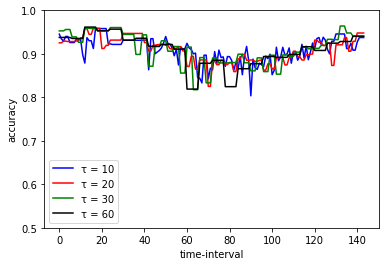

In [73]:
plt.xlabel('time-interval')
plt.ylabel('accuracy')
time = [i for i in range(144)]
plt.ylim(0.5, 1)
plt.plot(time, plt10_min_to_10, "b", label="\u03C4 = 10")
plt.plot(time, plt20_min_to_10, "r", label="\u03C4 = 20")
plt.plot(time, plt30_min_to_10, "g", label="\u03C4 = 30")
plt.plot(time, plt60_min_to_10, "black", label="\u03C4 = 60")
plt.legend(loc="lower left")
plt.savefig("different_tau_values.svg", format="svg")
plt.savefig("different_tau_values.pdf", format="pdf")
plt.show()